In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Noise Statistics

Noise is inherently *random*, so we can't predict its exact value. This is why it's a problem. Imagine, for example, that some experiment measures a signal plus some noise: $s + n$. If we knew the exact value of $n$, it wouldn't be a problem, for we could just subtract it from our final measurement. But if $n$ is random (which it generally is), we can't do that. We'll see soon, though, that we can mitigate the effects of noise by making *repeated measurements*.

## Describing Noise

To understand noise, we need to understand its behavior. Even though we might not know the exact noise contribution for any given measurement (again, it's random!), we can understand its rough behavior. For example, coin flips might be random, so for any individual coin flip I might not know whether to expect heads or tails. But I do know something about the nature of coin flips! I know that there are two possibilities (heads/tails), and they're rougnly equally likely.

The properties of random quantities like noise are often described using <b>probability distribution functions</b>. A probability distribution function tells us how likely different outcomes of a random process are. For the coin-flipping example, the probability distribution function might look something like this:

[<matplotlib.text.Text at 0x112053cd0>, <matplotlib.text.Text at 0x11203e810>]

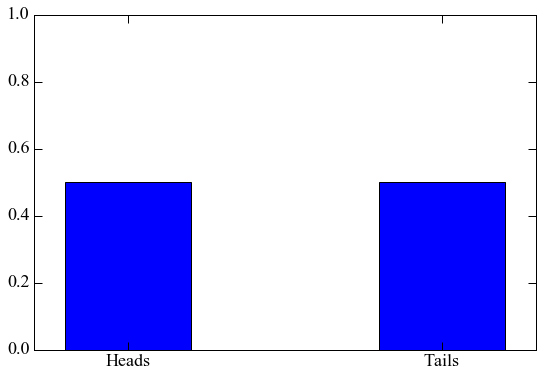

In [19]:
f, ax = plt.subplots(figsize=(9,6))
ax.bar(np.array([-0.25,0.25]), np.array([0.5, 0.5]),np.array([0.2, 0.2]))
ax.set_ylim(0,1)
ax.set_xticks(np.array([-0.15,0.35]))
ax.set_xticklabels(('Heads', 'Tails'))

Here's another example:

In [20]:
def gauss(x,b,s):
    return np.exp(-0.5 * (x-b)**2 / s**2) /np.sqrt(2.*np.pi*s**2)

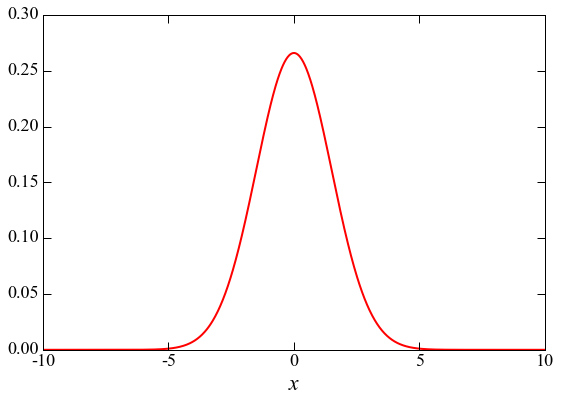

In [24]:
f, ax = plt.subplots(figsize=(9,6))
mean = 0.0
std = 1.5
xVals = np.linspace(-10.,10.,1000)
ax.plot(xVals, gauss(xVals, mean, std),lw=2,color='red')
ax.set_xlabel(r"$x$")

This is known as a Gaussian, or equivalently a normal distribution or a bell curve. Gaussians are characterized by their mean and their standard deviation. In this case, I plotted a Gaussian with mean zero and a standard deviation of $1.5$.

A random number governed by this probability distribution function is much more likely to be somewhere near zero (because that's where the probability distribution peaks). It's possible for this random number to take on a value that's far away from the mean, but it's much less likely (as seen from the way the Gaussian dies off rather quickly away from its peak).

In fact, here's a handy rule to remember. In the figure below, we've shaded the regions that are within one standard deviation of the mean (dark grey), two standard deviations (lighter grey), and three standard deviations (lightest grey). It turns out that $68\%$ of random numbers drawn from a Gaussian distribution fall within one standard deviation ("within one sigma"); $95\%$ fall within two standard deviations ("within two sigma"); and $99.7\%$ fall within three standard deviations ("within three sigma"). So while it is possible for a random number drawn from this distribution to be more than three sigma away from the mean, it's quite unlikely.

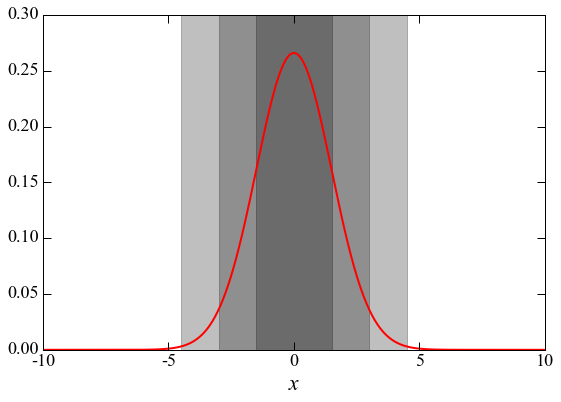

In [33]:
f, ax = plt.subplots(figsize=(9,6))
mean = 0.0
std = 1.5
xVals = np.linspace(-10.,10.,1000)
ax.plot(xVals, gauss(xVals, mean, std),lw=2,color='red')
ax.axvspan(-3.*std, 3.*std, alpha=0.25, color='black')
ax.axvspan(-2.*std, 2.*std, alpha=0.25, color='black')
ax.axvspan(-std, std, alpha=0.25, color='black')
ax.set_xlabel(r"$x$")

The language of "number of sigmas" is often used to describe how noisy a measurement is, or equivalently, how much we're able to "see" the signal above the contaminating noise. Suppose we've made a measurement $m$, which is the sum of the signal that we want $s$ and the noise $n$:

$m = s + n$

Suppose $n$ is Gaussian-distributed with mean zero and a standard deviation of $3$, while the signal has value $15$. We would call this a "five-sigma measurement", because the size of the signal is five times the standard deviation of the noise. This means that it's overwhelmingly likely that we've measured the signal rather than just noise. Said differently, it's possible that we got really unlucky and had in fact just measured some noise rather than signal. But to mimic the signal, the random noise would have to five standard deviations away from its mean, which we've just seen is highly unlikely.

## Averaging down noise

But how do we get to a low-noise measurement in the first place? Ideally, one can design an instrument that has very little noise by design. But this may not always be possible. So what do we do? Again, we can't easily subtract off the noise after the fact because it's random (which means we don't know ahead of time what value the noise is going to take).

The best that we can do is to make repeated measurements and to average them together. This tends to have the effect of averaging down the noise. The reason this works is that noise is often distributed with mean-zero Gaussian distributions like the ones we've plotted above. Notice that these distributions are symmetric about zero, which means that the noise is equally likely to be positive or negative. If we make many repeated measurements of the same signal, each time the noise will be different (otherwise it wouldn't be called random!) with it being positive roughly half the time and negative roughly half the time. If we average all our measurements together, the positive and negative noise contributions cancel each other out, and the average will tend to be less noisy than an individual measurement.

Let's try this out. I can simulate some noise by asking numpy to draw random numbers from a Gaussian distribution.

In [89]:
num_samples = 50000
sigma = 31.2
noise_samples = np.random.normal(scale=sigma, size=num_samples)

I picked a standard deviation of $31.2$, so if we take a peek at the numbers, we see that they're typically of that size:

In [90]:
print noise_samples[:15]

[ 15.06446975  39.04686486 -15.85655802 -51.24384466 -28.06541592
 -77.6472985   26.14207299   3.26870247 -41.33022005   8.78763174
 -50.73409185 -22.73161219  27.25016628  -2.8844408  -10.88717499]


But if I now average (say) the first $1000$ samples, I get a much smaller number because the positive and negative noise samples balance each other:

In [91]:
print np.mean(noise_samples[:1000])

1.15569647093


This means that if I make $1000$ measurements of the same thing and average the results, the result will be less noisy. Let's see how quickly this averaging occurs:

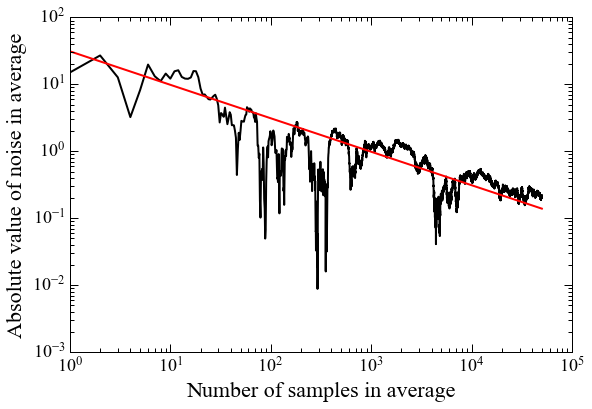

In [92]:
averaged = np.zeros_like(noise_samples)
for i in range(num_samples):
    averaged[i] = np.mean(noise_samples[:i+1])

f, ax = plt.subplots(figsize=(9,6))
ax.loglog(range(1,num_samples+1),abs(averaged),lw=2,color='black')
ax.loglog(range(1,num_samples+1),sigma/np.sqrt(range(1,num_samples+1)),lw=2,color='red')
ax.set_ylabel(r"Absolute value of noise in average")
ax.set_xlabel(r"Number of samples in average")

Here I've plotted the residual noise on the vertical axis against the number of samples that I've averaged together. Actually, I plotted the absolute value of the residual noise, since here we're worried only about how much the noise sways our answer, and not which way. The results (in black) exhibit lots of random fluctuations, but the noise seems to follow the overall trend of the red curve, which shows $\frac{\sigma}{\sqrt{N}}$,
where $\sigma$ is the standard deviation of the noise, and $N$ is the number of samples.

In our radio observations, every if we make one measurement every $\Delta t$ seconds and observe for a total of $t$ seconds, we end up with $N = t / \Delta t$ samples. This means that the noise in our measurement will tend to be proportional to $1/\sqrt{t}$. As expected, the longer we observe for, the less noisy our measurement.

If we plot $1/\sqrt{N}$ on a linear scale, we see that in a typical measurement it's very easy to drop to a moderate noise level pretty quickly, but to get to an extremely low noise takes a long time because the curve flattens out. For an instrument like HERA, we'll need to observe for about $1000$ hours to get to the sensitivity levels that we want!

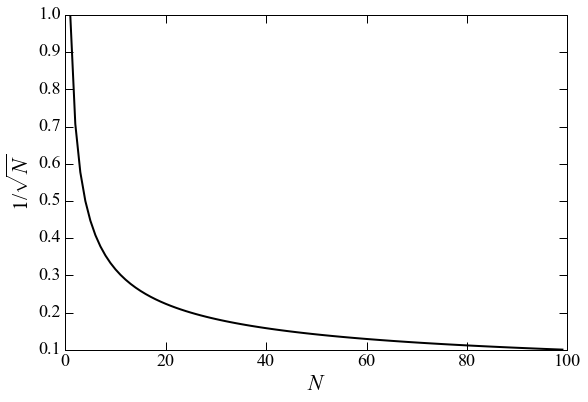

In [97]:
f, ax = plt.subplots(figsize=(9,6))
ax.plot(range(1,100), 1/np.sqrt(np.array(range(1,100))), lw=2, color='black')
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$1/\sqrt{N}$")